In [1]:
from collections import OrderedDict
import sys
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn

import torchvision as tv
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import functional as tfunc

sys.path.append('../mine_soar')
import MalmoPython
from odin import draw_image, draw_layers, ViewGenerator

In [8]:
rn50 = resnet50()
print(rn50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, fpn_dim=256):
        super().__init__()
        self.num_fpn_stages = 4
        self.fpn_dim = fpn_dim
        self.fpn = tv.ops.FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 2048], out_channels=fpn_dim
        )
        self.feat_extender_1 = nn.Sequential(
            nn.ConvTranspose2d(fpn_dim, fpn_dim, 4, 2, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True)
        )
        self.downscaler = nn.Sequential(
            nn.Conv2d(4, fpn_dim, 4, 2, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True)
        )
        self.feat_extender_2 = nn.Sequential(
            nn.ConvTranspose2d(fpn_dim, fpn_dim, 4, 2, 1),
            nn.BatchNorm2d(fpn_dim),
            nn.ReLU(inplace=True)
        )
        
        self.activation = {}
#         self.resnet50_backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet50_backbone = resnet50()
        self.resnet50_backbone.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.resnet50_backbone.layer1.register_forward_hook(self.get_activation('conv2'))
        # self.resnet50_backbone.layer2.register_forward_hook(self.get_activation('conv3'))
        # self.resnet50_backbone.layer3.register_forward_hook(self.get_activation('conv4'))
        # self.resnet50_backbone.layer4.register_forward_hook(self.get_activation('conv5'))
        
        # self.fpn_stage_1 = nn.Conv2d(2048, self.fpn_dim, kernel_size=1)
        # self.fpn_stage_2 = FPNStage(self.fpn_dim, 1024)
        # self.fpn_stage_3 = FPNStage(self.fpn_dim, 512)
        # self.fpn_stage_4 = FPNStage(self.fpn_dim, 256)
        
    def forward(self, input):
        out = self.resnet50_backbone.conv1(input)
        out = self.resnet50_backbone.bn1(out)
        out = self.resnet50_backbone.relu(out)
        out = self.resnet50_backbone.maxpool(out)
        
        feat0 = self.resnet50_backbone.layer1(out)
        feat1 = self.resnet50_backbone.layer2(feat0)
        feat2 = self.resnet50_backbone.layer3(feat1)
        feat3 = self.resnet50_backbone.layer4(feat2)

        feats = OrderedDict()
        feats["0"] = feat0
        feats["1"] = feat1
        feats["2"] = feat2
        feats["3"] = feat3

        extracted_feats = self.fpn(feats)['0']        
        out_feats = self.feat_extender_1(extracted_feats)
        
        downscaled_input = self.downscaler(input)
        out_feats = out_feats + downscaled_input
        out_feats = self.feat_extender_2(out_feats)
        # dense_feats = out_feats["3"]
        # flat_feats = self.resnet.avgpool(dense_feats)
        # flat_feats = torch.flatten(flat_feats, 1)


        # fpn_stage_1_output = self.fpn_stage_1(self.activation['conv5'])
        # fpn_stage_2_output = self.fpn_stage_2(self.activation['conv4'], fpn_stage_1_output)
        # fpn_stage_3_output = self.fpn_stage_3(self.activation['conv3'], fpn_stage_2_output)
        # fpn_stage_4_output = self.fpn_stage_4(self.activation['conv2'], fpn_stage_3_output)

        return out_feats
#         return out_feats["0"]

In [10]:
MISSION_PORT = 9001
MISSION_FILE = Path("random_world.xml")
VIDEO_SHAPE = (512, 512)
VIDEO_DEPTH = 4
DEVICE = 'cuda:0'

feat_ext = FeatureExtractor().to('cuda:0')

In [4]:
MISSION_FILE = Path("random_world.xml")
malmo_agent_host = MalmoPython.AgentHost()
malmo_client_info = MalmoPython.ClientInfo('127.0.0.1', MISSION_PORT)
malmo_client_pool = MalmoPython.ClientPool()
malmo_client_pool.add(malmo_client_info)

random_world_mission_spec = MalmoPython.MissionSpec(MISSION_FILE.read_text(), True)
random_world_record_spec = MalmoPython.MissionRecordSpec()
malmo_agent_host.startMission(random_world_mission_spec, 
                              malmo_client_pool,
                              random_world_record_spec,
                              0,
                              "TEST ALPHA")

In [5]:
state = malmo_agent_host.getWorldState()
vision = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
vision = vision.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))
demo_tensor = tfunc.to_tensor(vision).to(DEVICE).unsqueeze(0)

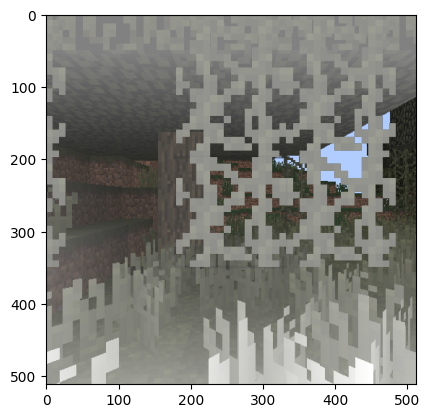

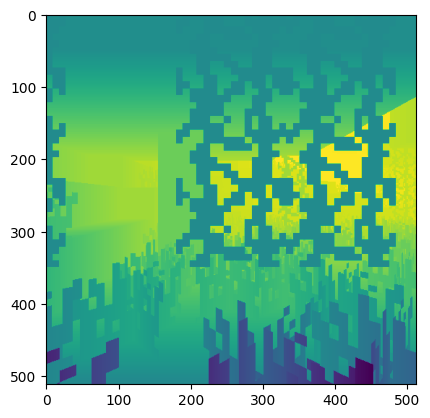

123


In [6]:
state = malmo_agent_host.getWorldState()
vision = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
vision = vision.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))
demo_tensor = tfunc.to_tensor(vision).to(DEVICE).unsqueeze(0)

plt.imshow(vision)
plt.show()
plt.close()

plt.imshow(vision[:,:,-1])
plt.show()
plt.close()

print(vision[:,:,-1][255,255])

In [11]:
demo_out = feat_ext(demo_tensor)
print(demo_out.shape)

torch.Size([1, 256, 512, 512])


In [ ]:
draw_layers(demo_out, show=True)

In [ ]:
MISSION_FILE = Path("../mine_soar/chessboard.xml")
malmo_agent_host = MalmoPython.AgentHost()
malmo_client_info = MalmoPython.ClientInfo('127.0.0.1', MISSION_PORT)
malmo_client_pool = MalmoPython.ClientPool()
malmo_client_pool.add(malmo_client_info)

random_world_mission_spec = MalmoPython.MissionSpec(MISSION_FILE.read_text(), True)
random_world_record_spec = MalmoPython.MissionRecordSpec()
malmo_agent_host.startMission(random_world_mission_spec, 
                              malmo_client_pool,
                              random_world_record_spec,
                              0,
                              "TEST ALPHA")

In [ ]:
malmo_agent_host.sendCommand("quit")

In [ ]:
images = []

In [ ]:
state = malmo_agent_host.getWorldState()
image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
image = image.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))
plt.imshow(image)
plt.show()
plt.close()
retval, corners = cv2.findChessboardCorners(image, (6,7))
print(retval)
if retval:
    images.append(image)
    corners_img = cv2.drawChessboardCorners(image.copy(), (6,7), corners, False)
    plt.imshow(corners_img)
    plt.show()
    plt.close()

In [ ]:
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:7].T.reshape(-1,2)

In [ ]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [ ]:
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    retval, corners = cv2.findChessboardCorners(image, (6,7))
    if retval:        
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        corners_img = cv2.drawChessboardCorners(image.copy(), (6,7), corners2, retval)
        plt.imshow(corners_img)
        plt.show()
        plt.close()

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [ ]:
state = malmo_agent_host.getWorldState()
image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
image = image.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))
h, w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [ ]:
fixed_image = cv2.undistort(image, newcameramtx, dist, None, mtx)

In [ ]:
plt.imshow(fixed_image)
plt.show()
plt.close()

In [ ]:
FOV_v = 70
FOV_h = FOV_v
H, W = VIDEO_SHAPE
P_delta = torch.Tensor([[((r/H)*FOV_v)-(FOV_v/2) for c in range(W)] for r in range(H)])
Y_delta = torch.Tensor([[((c/W)*FOV_h)-(FOV_h/2) for c in range(W)] for r in range(H)])

def get_xyz_coords(image, position, heading):
    pos_x, pos_y, pos_z = position
    pitch, yaw = heading
    P_adj = (P_delta + pitch)*(3.14159/180)
    Y_adj = (Y_delta + yaw)*(3.14159/180)
    V_x = -torch.sin(Y_adj) * torch.cos(P_adj)
    V_y = -torch.sin(P_adj)
    V_z = torch.cos(Y_adj) * torch.cos(P_adj)
    V = torch.concat([V_x.expand(1,512,512), V_y.expand(1,512,512), V_z.expand(1,512,512)])
    D = image[:,3,:,:]
    D_adj = D*V
    I = D_adj+torch.Tensor(position).reshape(1,3,1,1)
    return I

In [ ]:
img_tensor = tfunc.to_tensor(image).unsqueeze(0)
points = get_xyz_coords(img_tensor, (-202,67,244), (7.2, 120.4))

In [ ]:
points_np = np.transpose(points.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_3d = o3d.utility.Vector3dVector(points_np)
point_cloud = o3d.geometry.PointCloud(points_3d)
point_cloud.colors = o3d.utility.Vector3dVector(image[:,:,:3].reshape((512*512, 3))/256)
o3d.visualization.draw_geometries([point_cloud])

In [ ]:
state = malmo_agent_host.getWorldState()
image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
image = image.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))

# obs = json.loads(state.observations[0].text)
# dist = obs['LineOfSight']['distance'] 
# scale_factor = image[:,:,-1][256,256]/dist
# image = (image/[1,1,1,scale_factor])

h, w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
fixed_image_a = cv2.undistort(image, newcameramtx, dist, None, mtx)
pitch_a = -9.4
yaw_a = -141.8
x_a, y_a, z_a = (127.136, 69, 189.843)

In [ ]:
state = malmo_agent_host.getWorldState()
image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
image = image.reshape(VIDEO_SHAPE+(VIDEO_DEPTH,))

# obs = json.loads(state.observations[0].text)
# dist = obs['LineOfSight']['distance'] 
# scale_factor = image[:,:,-1][256,256]/dist
# image = (image/[1,1,1,scale_factor])

h, w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
fixed_image_b = cv2.undistort(image, newcameramtx, dist, None, mtx)
pitch_b = 4-22.9
yaw_b = 165.9
x_b, y_b, z_b = (131.7, 67, 190.7)

In [ ]:
img_tensor_a = tfunc.to_tensor(fixed_image_a).unsqueeze(0)
points_a = get_xyz_coords(img_tensor_a, (x_a, y_a, z_a), (pitch_a, yaw_a))

In [ ]:
img_tensor_b = tfunc.to_tensor(fixed_image_b).unsqueeze(0)
points_b = get_xyz_coords(img_tensor_b, (x_b, y_b, z_b), (pitch_b, yaw_b))

In [ ]:
points_a_np = np.transpose(points_a.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_a_3d = o3d.utility.Vector3dVector(points_a_np)
point_cloud_a = o3d.geometry.PointCloud(points_a_3d)
point_cloud_a.colors = o3d.utility.Vector3dVector(fixed_image_a[:,:,:3].reshape((512*512, 3))/256)
o3d.visualization.draw_geometries([point_cloud_a])

In [ ]:
points_b_np = np.transpose(points_b.numpy().squeeze(), (1,2,0)).astype(np.float64).reshape((512*512,3))
points_b_3d = o3d.utility.Vector3dVector(points_b_np)
point_cloud_b = o3d.geometry.PointCloud(points_b_3d)
point_cloud_b.colors = o3d.utility.Vector3dVector(fixed_image_b[:,:,:3].reshape((512*512, 3))/256)
o3d.visualization.draw_geometries([point_cloud_b])

In [ ]:
o3d.visualization.draw_geometries([point_cloud_a, point_cloud_b])

In [ ]:
draw_image(fixed_image[:,:,-1], show=True)

In [ ]:
fixed_image[:,:,-1][255,255]